# Feature Enrichment 

There are 3 ways to enrich the data:
1. Feature Extraction: obtaining new features from existing features.
2. Feature Engineering: transformation of raw data into features suitable for modeling.
3. Feature Transformation: transformation of data to improve the accuracy of the algorithm.

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv("flat_file_after_data_cleansing.csv")


C:\Users\itzikjan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Expanding the output display to see more rows and columns:
pd.set_option('display.max_rows', 200 , 'display.max_columns', 200)

In [3]:
df.head(3)

,Unnamed: 0,listing_id,name,target_start_date_period,target_end_date_period,target_avg_dollar_price_in_period,start_date_previous_period,end_date_previous_period,host_id,host_name,...,review_scores_rating_cat,reviews_per_month_cat,DaysPassed_first_review_cat,DaysPassed_last_review_cat,beds_cat,bathrooms_cat,DaysPassed_host_since_cat,host_total_listings_count_cat,bedrooms_cat,sqrt_bedrooms_cat
0,0,7071,BrightRoom with sunny greenview!,2019-06-01,2019-08-31,NaN,2018-11-07,2019-05-31,17391,Bright,...,review_scores_rating_25%_to_50%,reviews_per_month_75%_to_100%,DaysPassed_first_review_75%_to_100%,DaysPassed_last_review_0%_to_25%,beds_50%_to_75%,bathrooms_0%_to_25%,DaysPassed_host_since_75%_to_100%,host_total_listings_count_0%_to_25%,bedrooms_0%_to_25%,sqrt_bedrooms_0%_to_25%
1,1,7071,BrightRoom with sunny greenview!,2019-07-01,2019-09-30,NaN,2018-11-07,2019-06-30,17391,Bright,...,review_scores_rating_25%_to_50%,reviews_per_month_75%_to_100%,DaysPassed_first_review_75%_to_100%,DaysPassed_last_review_0%_to_25%,beds_50%_to_75%,bathrooms_0%_to_25%,DaysPassed_host_since_75%_to_100%,host_total_listings_count_0%_to_25%,bedrooms_0%_to_25%,sqrt_bedrooms_0%_to_25%
2,2,7071,BrightRoom with sunny greenview!,2019-08-01,2019-11-06,NaN,2018-11-07,2019-07-31,17391,Bright,...,review_scores_rating_25%_to_50%,reviews_per_month_75%_to_100%,DaysPassed_first_review_75%_to_100%,DaysPassed_last_review_0%_to_25%,beds_50%_to_75%,bathrooms_0%_to_25%,DaysPassed_host_since_75%_to_100%,host_total_listings_count_0%_to_25%,bedrooms_0%_to_25%,sqrt_bedrooms_0%_to_25%


In [6]:
def drop_additional_index_columns(_df):
    # dropping additional index columns that start with "Unnamed" - dropping these columns
    columns_to_drop = [x for x in _df.columns.to_list() if x.startswith("Unnamed")]
    print("dropping coulmns: ", columns_to_drop) # [Unamed..., Unamed..]
    return _df.drop(columns=columns_to_drop, axis=1, inplace=False)

df = drop_additional_index_columns(df)

dropping coulmns:  ['Unnamed: 0']


In [5]:
# Representing the dimensionality of the DataFrame (before adding new variables):
df.shape

(157864, 134)

In [8]:
df.info(verbose=True, null_counts=True)

C:\Users\itzikjan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157864 entries, 0 to 157863
Data columns (total 134 columns):
 #    Column                                   Non-Null Count   Dtype  
---   ------                                   --------------   -----  
 0    listing_id                               157864 non-null  int64  
 1    name                                     157451 non-null  object 
 2    target_start_date_period                 157864 non-null  object 
 3    target_end_date_period                   157864 non-null  object 
 4    target_avg_dollar_price_in_period        43919 non-null   float64
 5    start_date_previous_period               157864 non-null  object 
 6    end_date_previous_period                 157864 non-null  object 
 7    host_id                                  157864 non-null  int64  
 8    host_name                                157682 non-null  object 
 9    neighbourhood_group                      157864 non-null  object 
 10   neighbourhood     

### Feature Extraction

The addtional variables that were created in "Addition to Flat file" notebook are:
1. size - extract it from the "description" column.
2. concat_comments_polarity (Sentiment Analysis) - extract from "concat_comments" column
3. concat_comments_subjectivity (Sentiment Analysis) - extract from "concat_comments" column
4. concat_comments_sentiment  (Sentiment Analysis) - extract from "concat_comments" column

This variables were created in the Addition to Flat file notebook because these include NA and need to be handled in the EDA and in the Data Cleansing section. 


### Feature Engineering

In Feature Engineering I based on the pattern I found in the EDA section.

#### availability

We saw in the EDA section that there are 4 similar variables - availability_30, availability_60, availability_90 and availability_365. Those variables have high correlation (more than 0.8), so I will keep 

In [165]:
X = df[["availability_30", "availability_60", "availability_90","availability_365"]]
X.head(1)


,availability_30,availability_60,availability_90,availability_365
0,15.0,26.0,26.0,26.0


In [167]:
# create a k-means object with 2 clusters
kmeans = KMeans(2)
# fit the data
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [168]:
# create a copy of data, so we can see the clusters next to the original data
clusters = df.copy()
# predict the cluster for each observation
clusters['cluster_pred']=kmeans.fit_predict(X)

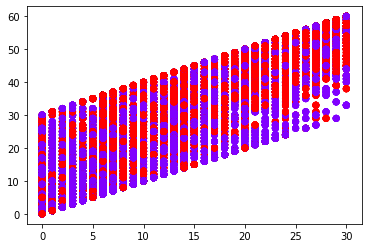

In [169]:
# create a scatter plot based on two corresponding features (sepal_length and sepal_width; OR petal_length and petal_width)
plt.scatter(clusters['availability_30'], clusters['availability_60'], c= clusters ['cluster_pred'], cmap = 'rainbow')

In [7]:
df_eda_numric_correlations = pd.read_csv("eda_numric_correlations.csv")
df_eda_numric_correlations = drop_additional_index_columns(df_eda_numric_correlations)
df_eda_numric_correlations

dropping coulmns:  ['Unnamed: 0']


,var1,var2,target,correlation_between_vars,pvalue_between_vars,correlation_var1_target,pvalue_var1_target,correlation_var2_target,pvalue_var2_target
0,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,booked_up_target,0.982365,0.0,NaN,NaN,-0.120453,7.034347e-251
1,availability_60,availability_90,booked_up_target,0.957945,0.0,-0.497006,0.000000e+00,-0.559652,0.000000e+00
2,target_avg_dollar_price_in_period,price,booked_up_target,0.951098,0.0,NaN,NaN,-0.205355,0.000000e+00
3,weekly_price,monthly_price,booked_up_target,0.925822,0.0,-0.183143,3.604881e-193,-0.191507,3.043746e-153
4,avg_dollar_price_in_previous_period,price,booked_up_target,0.917291,0.0,-0.120453,7.034347e-251,-0.205355,0.000000e+00
...,...,...,...,...,...,...,...,...,...
877,occupancy_last_period,availability_30,booked_up_target,-0.785183,0.0,0.696799,0.000000e+00,-0.421644,0.000000e+00
878,DaysPassed_last_review,reviews_per_month,booked_up_target,-0.818013,0.0,0.324409,0.000000e+00,-0.266835,0.000000e+00
879,occupancy_last_period,availability_60,booked_up_target,-0.894064,0.0,0.696799,0.000000e+00,-0.497006,0.000000e+00
880,occupancy_last_period,availability_365,booked_up_target,-0.938229,0.0,0.696799,0.000000e+00,-0.788367,0.000000e+00


In [8]:
# TODO Taken from EDA after using all_numric_correlations
def get_numeric_cols_to_drop_by_correlation(_df_numric_correlations, correlation_between_vars_threshold = 0.8):
    """
    _df_numric_correlations has the following columns
    ['var1', 'var2', 'target', 'correlation_between_vars',
           'pvalue_between_vars', 'correlation_var1_target', 'pvalue_var1_target',
           'correlation_var2_target', 'pvalue_var2_target']
    """
    # get rows that 2 vars/features have high correlation between them. 
    df_numric_correlations_filter_by_corr = _df_numric_correlations[np.abs(_df_numric_correlations['correlation_between_vars'])>=correlation_between_vars_threshold]
    display(df_numric_correlations_filter_by_corr)
    columns_to_drop = set()
    # for each row we drop the var that has low correlation with target column
    for idx, row in df_numric_correlations_filter_by_corr.iterrows():
        correlation_var1_target = row['correlation_var1_target']
        correlation_var2_target = row['correlation_var2_target']
        if correlation_var1_target and correlation_var2_target and np.abs(correlation_var1_target) > np.abs(correlation_var2_target):
            columns_to_drop.add(row['var2'])
        else:
            columns_to_drop.add(row['var1'])
    return columns_to_drop

numeric_cols_to_drop = get_numeric_cols_to_drop_by_correlation(df_eda_numric_correlations)
print(numeric_cols_to_drop)

,var1,var2,target,correlation_between_vars,pvalue_between_vars,correlation_var1_target,pvalue_var1_target,correlation_var2_target,pvalue_var2_target
0,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,booked_up_target,0.982365,0.0,NaN,NaN,-0.120453,7.034347e-251
1,availability_60,availability_90,booked_up_target,0.957945,0.0,-0.497006,0.000000e+00,-0.559652,0.000000e+00
2,target_avg_dollar_price_in_period,price,booked_up_target,0.951098,0.0,NaN,NaN,-0.205355,0.000000e+00
3,weekly_price,monthly_price,booked_up_target,0.925822,0.0,-0.183143,3.604881e-193,-0.191507,3.043746e-153
4,avg_dollar_price_in_previous_period,price,booked_up_target,0.917291,0.0,-0.120453,7.034347e-251,-0.205355,0.000000e+00
5,availability_30,availability_60,booked_up_target,0.907023,0.0,-0.421644,0.000000e+00,-0.497006,0.000000e+00
6,calculated_host_listings_count,host_total_listings_count,booked_up_target,0.901281,0.0,-0.268586,0.000000e+00,-0.267512,0.000000e+00
7,availability_365,availability_90,booked_up_target,0.875757,0.0,-0.788367,0.000000e+00,-0.559652,0.000000e+00
8,availability_30,availability_90,booked_up_target,0.851459,0.0,-0.421644,0.000000e+00,-0.559652,0.000000e+00
9,price,weekly_price,booked_up_target,0.839673,0.0,-0.205355,0.000000e+00,-0.183143,3.604881e-193


{'occupancy_last_period', 'avg_dollar_price_in_previous_period', 'target_num_of_day_in_period', 'availability_30', 'host_total_listings_count', 'target_avg_dollar_price_in_period', 'availability_60', 'reviews_per_month', 'availability_90', 'weekly_price'}


In [ ]:
Explantion of the reuslts:
1. 'availability_30', 'availability_60', 'availability_90' and 'availability_365' have high correlation between each of them (correlatioin is more than  80%). The fucntion keeps only 'availability_365' var because this var has the highest correlation with the target. 
2. "target_avg_dollar_price_in_period", "avg_dollar_price_in_previous_period", "weekly_price" and "price" have high correlatioin between each of them but "price" has the highest correlation to target. 
Also, monthly_price is not dropped because it doesn't have correlation with price. 

In [ ]:
df_eda_pval_of_categorical_columns = pd.read_csv("eda_pval_of_categorical_columns.csv")

df_eda_pval_of_categorical_columns = drop_additional_index_columns(df_eda_pval_of_categorical_columns)
df_eda_pval_of_categorical_columns

In [ ]:
def get_dummies_of_2_vars(_df, _col1, _col2, unique_values_limitation=7):
    """
    "create dummies" of 2 categorical colums -> create new column for each possibale metch of value. 
    """
    col1_unique_values = _df[_col1].unique()
    col2_unique_values = _df[_col2].unique()
    col1_unique_count = len(col1_unique_values)
    col2_unique_count = len(col2_unique_values)
    if unique_values_limitation != None:
        if  col1_unique_count > unique_values_limitation or col2_unique_count > unique_values_limitation:
            print(f'{_col1} has {col1_unique_count} unique values and {_col2} has {col2_unique_count} unique values - Not creating dummies ')
            return _df
    print(_col1, "number of unique values: ", len(col1_unique_values))
    print(_col2, "number of unique values: ", len(col2_unique_values))
    added_columns = []
    def _is_dummy(_row_val_1,_unique_val1,_row_val_2 ,_unique_val2):
        if _row_val_1 == _unique_val1 and _row_val_2 == _unique_val2:
            return 1
        else:
            return 0
        
    for unique_val_1 in col1_unique_values:
        for unique_val_2 in col2_unique_values:
            new_col = "_".join([_col1, unique_val_1, _col2, unique_val_2])
            added_columns.append(new_col)
            print("new_col:", new_col)
            _df[new_col] = _df.apply(lambda row:_is_dummy(row[_col1], unique_val_1, row[_col2], unique_val_2),axis=1)
    print("number of added columns", len(added_columns))
    return _df

###############################################################################################
#### Test
###############################################################################################
df_test = pd.DataFrame({"my_col_1":["a1", "a2", "a1","a1"], "my_col_2": ["b1", "b1", "b2", "b2"]})
df_actual_test = get_dummies_of_2_vars(df_test, 'my_col_1', "my_col_2")
display(df_actual_test)
df_expected_test = pd.DataFrame({"my_col_1":["a1", "a2", "a1","a1"], "my_col_2": ["b1", "b1", "b2", "b2"], 
                           "my_col_1_a1_my_col_2_b1": [1, 0 , 0 ,0],
                           "my_col_1_a1_my_col_2_b2": [0, 0, 1 , 1],
                           "my_col_1_a2_my_col_2_b1": [0, 1, 0, 0],
                           "my_col_1_a2_my_col_2_b2": [0, 0, 0, 0]})

pd.testing.assert_frame_equal(df_actual_test,df_expected_test)

In [ ]:
df_eda_pval_of_categorical_columns

In [9]:
from datetime import datetime


df_pval_of_categorical_columns
num_of_uniqiue_values = {}
for index, row in df_eda_pval_of_categorical_columns.iterrows():
    start_time = datetime.now()
    df = get_dummies_of_2_vars(df, row['var1'], row['var2'], 5)
    end_time = datetime.now()
    print(row['var1'], row['var2'], "total time: ", end_time-start_time)

NameError: name 'df_pval_of_categorical_columns' is not defined

In [17]:
#Create column which indicates distance from center based on latitude and longitude variables.

#Get Berlin coordinates
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
#https://www.latlong.net/place/berlin-germany-9966.html

from geopy.distance import great_circle
def distance_from_berlin(lat, lon):
    berlin_centre = (52.50277, 13.404166)
    record = (lat, lon)
    return great_circle(berlin_centre, record).km

#add distanse dataset
df['distance'] = df.apply(lambda x: distance_from_berlin(x.latitude, x.longitude), axis=1)


df.head(1)

,listing_id,name,target_start_date_period,target_end_date_period,target_avg_dollar_price_in_period,start_date_previous_period,end_date_previous_period,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,last_review,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,notes,transit,access,interaction,house_rules,neighborhood_overview,host_about,host_since,picture_url,host_url,host_location,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,market,country_code,country,is_location_exact,property_type,bed_type,amenities,square_feet,weekly_price,monthly_price,calendar_updated,first_review,calendar_last_scraped,license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,concat_comments,concat_comments_sentiment,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,DaysPassed_host_since,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,DaysPassed_first_review,review_scores_rating,...,pack_���n_play/travel_crib,shower_chair,high_chair,microwave,carbon_monoxide_detector,well-lit_path_to_entrance,wide_doorway,shampoo,ethernet_connection,kitchenette,heating,accessible-height_toilet,kitchen,children���s_books_and_toys,translation_missing:_en.hosting_amenity_49,crib,stove,bathtub_with_bath_chair,toilet_paper,other_pet(s),fireplace_guards,dryer,room-darkening_shades,bathtub,game_console,children���s_dinnerware,air_conditioning,cable_tv,hot_tub,electric_profiling_bed,fixed_grab_bars_for_shower,toilet,buzzer/wireless_intercom,convection_oven,window_guards,ceiling_hoist,bathroom_essentials,gym,hot_water,pocket_wifi,wide_hallway_clearance,long_term_stays_allowed,sound_system,free_parking_on_premises,stair_gates,beachfront,dishes_and_silverware,bath_towel,pets_live_on_this_property,body_soap,breakfast_table,wide_clearance_to_bed,step-free_access,bbq_grill,iron,changing_table,24-hour_check-in,laptop_friendly_workspace,baby_monitor,firm_mattress,single_level_home,hair_dryer,private_living_room,fixed_grab_bars_for_toilet,netflix,keypad,roll-in_shower,safety_card,indoor_fireplace,luggage_dropoff_allowed,air_purifier,other,washer_/_dryer,lock_on_bedroom_door,lockbox,outlet_covers,patio_or_balcony,coffee_maker,cat(s),suitable_for_events,pets_allowed,waterfront,essentials,tv,self_check-in,hot_water_kettle,babysitter_recommendations,first_aid_kit,wheelchair_accessible,oven,extra_pillows_and_blankets,private_entrance,private_bathroom,beach_essentials,family/kid_friendly,wide_entryway,flat_path_to_front_door,translation_missing:_en.hosting_amenity_50,pool,distance
0,7071,BrightRoom with sunny greenview!,2019-06-01,2019-08-31,NaN,2018-11-07,2019-05-31,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,2018-11-04,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",Cozy and large room in the beautiful district ...,none,I hope you enjoy your stay to the fullest! Ple...,Best access to other parts of the city via pub...,"The guests have access to the bathroom, a smal...",I am glad if I can give you advice or help as ...,Please take good care of everything during you...,"Great neighborhood with plenty of Caf��s, Bake...","I'm a creative person, adventurer, and travele...",2009-05-16,https://a0.muscache

### Feature Transformation

In [170]:
#Create new column for host_location with 2 values in/out of Germany
#Previously, we replaced nans of host location with DE. After searching the values
#we create a new column host_in_germany to inspect if hosts located to other countries differ their listings' prices.
def host_in_germany(row):
   if (('Germany' in row['host_location']) | ('DE' in row['host_location'])):
       return 'Yes'
   else:
       return 'No'

df['host_in_germany'] = df.apply(lambda row: host_in_germany(row), axis=1)

TypeError: argument of type 'float' is not iterable

In [ ]:
#Create column total_months_hosting from today - host_since (in months)
df['host_total_months'] = ((pd.to_datetime('today') - df['host_since'])/np.timedelta64(1, 'M'))
df['host_total_months'] = df['host_total_months'].astype(int)

#Drop host_since
df.drop(['host_since'], axis=1, inplace=True)

In [141]:
import itertools

def from_col_list_to_is_exists_columns(_df, col_of_list , ignore_values_list = ['a','']):
    # itreate on all rows and get all optional values in col_of_list
    # create list of unique values.
    # create df of col_of_list without None
    df_col = _df[pd.isna(_df[col_of_list]) == False ][col_of_list]
   
    merged = list(itertools.chain(*df_col.to_list())) 
    #display(df_col)
    # each row in df_col conatins list of strs, flat all list to single list
    flat_list = list(itertools.chain(*df_col.to_list())) 
    # print(flat_list)
    list_of_columns_to_add = list(set(flat_list)-set(ignore_values_list))
    # add column be each value of the list (equivalent for creating one hot encoding/dummies)
    
    for new_col in list_of_columns_to_add:
        is_exists = new_col in _df[col_of_list]
        
        _df[new_col] = _df[col_of_list].apply(lambda x: 1  if (x and new_col in x) else 0 )
    
    return _df
        
######################################################################
# Testing
######################################################################        
df_test = pd.DataFrame({'amenities_list': [["tv", "cable_tv"],["heating", "washer"]] } )
df_test = from_col_list_to_is_exists_columns(df_test, col_of_list = 'amenities_list')

df_expected = pd.DataFrame({'amenities_list': [["tv", "cable_tv"],["heating", "washer"]], "tv": [1,0], "cable_tv":[1,0], "heating":[0,1], "washer": [0,1] })
pd.testing.assert_frame_equal(df_test,df_expected[df_test.columns])


#### Transform "Amenities" column (set of attributes) column to Dummies columns
Amenities columns contains dict of attribute. Transform each attribute to feature.
From all attributes that appears in amenities, creating multiple features (equivalent to making dummies/One hot encoding).

In [9]:
df['amenities'][1]

'{Wifi,Heating,"Family/kid friendly",Essentials,Shampoo,Hangers,"Hair dryer","Laptop friendly workspace","translation missing: en.hosting_amenity_50","Hot water","Bed linens","Extra pillows and blankets","Single level home"}'

In [10]:
def set_to_list(amenities_val):
    # amenities_val is set of words that is kept in str. Example '{TV,"Cable TV",Wifi,Kitchen,Gym, ... }')
    amenities_str = str(amenities_val)[1:-1].split(",") # ['TV', '"Cable TV"', 'Wifi', 'Kitchen', 'Gym']
    
    # remove "" from prases with spaces, replace spaces with _ and cast prases to lower
    return [s.strip('"').lstrip().lower().replace(" ", "_") for s in amenities_str]


# Test set_to_list method
df_test = pd.DataFrame({'amenities': ['{TV,"Cable TV",Wifi,Kitchen,Gym}', '{Heating,Washer,Essentials,Shampoo,"Hair dryer"}']} )
df_test['amenities_list'] = df_test['amenities'].apply(set_to_list)

df_expected = pd.DataFrame({'amenities': ['{TV,"Cable TV",Wifi,Kitchen,Gym}', '{Heating,Washer,Essentials,Shampoo,"Hair dryer"}'],
                           'amenities_list': [["tv", "cable_tv", "wifi", "kitchen", "gym"],["heating", "washer", "essentials", "shampoo", "hair_dryer"]] } )

pd.testing.assert_frame_equal(df_test,df_expected)



In [11]:
df['amenities_list'] = df['amenities'].apply(set_to_list)

In [126]:
df = from_col_list_to_is_exists_columns(df, col_of_list = 'amenities_list')

#### Transform "host_verifications" column (set of attributes) column to Dummies columns 
host_verifications columns contains list of attribute. Transform each attribute to feature.
From all attributes that appears in host_verifications, creating multiple features (equivalent to making dummies/One hot encoding).

In [102]:
df['host_verifications'][1]

"['email', 'phone', 'reviews', 'jumio', 'government_id']"

In [103]:
import ast
# host_verifications conatins list that transformed to str (repersented as string)
# ast.literal_eval can be use to transform back to list (from the str of list)
ast.literal_eval(df['host_verifications'][1])

['email', 'phone', 'reviews', 'jumio', 'government_id']

In [132]:
# host_verifications_list is the represntaion of host_verifications as list (intead of str)
df['host_verifications_list'] = df['host_verifications'].apply(ast.literal_eval)

In [139]:
df = from_col_list_to_is_exists_columns(df, col_of_list = 'host_verifications_list')

['sesame', 'email', 'identity_manual', 'phone', 'selfie', 'photographer', 'manual_offline', 'facebook', 'reviews', 'jumio', 'weibo', 'work_email', 'google', 'zhima_selfie', 'kba', 'government_id', 'sent_id', 'sesame_offline', 'manual_online', 'offline_government_id']


#### dummy encoding
add dummies encoding for categorical features

In [156]:
#  Defining the categorical variables:
category_cols = ['neighbourhood_group','room_type', 
'host_response_time','host_is_superhost','host_has_profile_pic',
'host_identity_verified', 'bed_type', 'instant_bookable','is_business_travel_ready','require_guest_profile_picture',
 'require_guest_phone_verification','cancellation_policy', 'concat_comments_sentiment']
# add the numeric categories that transfored to categories colums
category_cols += [x for x in df.columns.to_list() if x.endswith("cat")]

print(category_cols)

['neighbourhood_group', 'room_type', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'bed_type', 'instant_bookable', 'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification', 'cancellation_policy', 'concat_comments_sentiment', 'host_response_rate_cat', 'size_cat', 'avg_dollar_price_in_previous_period_cat', 'concat_comments_subjectivity_cat', 'concat_comments_polarity_cat', 'review_scores_value_cat', 'review_scores_checkin_cat', 'review_scores_location_cat', 'review_scores_communication_cat', 'review_scores_accuracy_cat', 'review_scores_cleanliness_cat', 'review_scores_rating_cat', 'reviews_per_month_cat', 'DaysPassed_first_review_cat', 'DaysPassed_last_review_cat', 'beds_cat', 'bathrooms_cat', 'DaysPassed_host_since_cat', 'host_total_listings_count_cat', 'bedrooms_cat', 'sqrt_bedrooms_cat']


In [157]:
df_with_dummies = pd.get_dummies(df, columns=category_cols)

In [158]:
dummies_coulmns = list(set(df_with_dummies.columns)-set(df.columns))
print(f"get_dummies method add {len(dummies_coulmns)} columns. The new columns are: ")
dummies_coulmns

get_dummies method add 124 columns. The new columns are: 


['DaysPassed_first_review_cat_DaysPassed_first_review_0%_to_25%',
 'DaysPassed_host_since_cat_DaysPassed_host_since_50%_to_75%',
 'DaysPassed_last_review_cat_DaysPassed_last_review_missing',
 'avg_dollar_price_in_previous_period_cat_avg_dollar_price_in_previous_period_missing',
 'neighbourhood_group_Spandau',
 'review_scores_communication_cat_review_scores_communication_missing',
 'require_guest_phone_verification_f',
 'DaysPassed_last_review_cat_DaysPassed_last_review_50%_to_75%',
 'size_cat_size_0%_to_25%',
 'DaysPassed_first_review_cat_DaysPassed_first_review_25%_to_50%',
 'host_response_rate_cat_host_response_rate_25%_to_50%',
 'DaysPassed_last_review_cat_DaysPassed_last_review_0%_to_25%',
 'review_scores_cleanliness_cat_review_scores_cleanliness_0%_to_25%',
 'neighbourhood_group_Charlottenburg-Wilm.',
 'host_is_superhost_f',
 'cancellation_policy_flexible',
 'host_response_time_within an hour',
 'cancellation_policy_super_strict_60',
 'require_guest_profile_picture_t',
 'review_sc

In [143]:
category_cols

['neighbourhood_group',
 'room_type',
 'host_response_time',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'bed_type',
 'instant_bookable',
 'is_business_travel_ready',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'cancellation_policy',
 'concat_comments_sentiment',
 'host_response_rate_cat',
 'size_cat',
 'avg_dollar_price_in_previous_period_cat',
 'concat_comments_subjectivity_cat',
 'concat_comments_polarity_cat',
 'review_scores_value_cat',
 'review_scores_checkin_cat',
 'review_scores_location_cat',
 'review_scores_communication_cat',
 'review_scores_accuracy_cat',
 'review_scores_cleanliness_cat',
 'review_scores_rating_cat',
 'reviews_per_month_cat',
 'DaysPassed_first_review_cat',
 'DaysPassed_last_review_cat',
 'beds_cat',
 'bathrooms_cat',
 'DaysPassed_host_since_cat',
 'host_total_listings_count_cat',
 'bedrooms_cat',
 'sqrt_bedrooms_cat']

### Feature Selection

Selection based on voting: using many of the techniques (univariate and multivariate), we make
a table with all the variables on the dataset and indicate the recommended variables for each
technique, then we select a threshold for the total votings and on this basis we select the variables
that will be used to train our models.